# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

**Step 1:** Import the data

The following libraries and packages are used for reading the csv files, processing the data and visualizing the data / images

In [1]:
# import necessary libraries for Milestone 1
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import re, cv2

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px

**Read CSV** : Read the car names and make and change the name of the column to "fullNames"

In [2]:
# read the car/class names
carsMaster = pd.read_csv("Car names and make.csv",header=None)
carsMaster.columns=["fullNames"]
carsMaster.head()

fullNames
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

**Read Word Count** : 

By understanding the length of the words, we can plan to split the OEM, Model, Type and Year part from the fullName

The following help us to understand that most of the entries are of 4 words and around 6 of them are having word length as 7

In [3]:
# lets review the name lengths
carsMaster["wCounts"] = carsMaster["fullNames"].apply(lambda x: len(x.split()))
carsMaster.wCounts.value_counts()

4    132
5     44
6     14
7      6
Name: wCounts, dtype: int64

**Visualize**

Print the entries with 7 words

In [4]:
# lets review the 7 word long names
print(carsMaster.loc[carsMaster.wCounts==7,["fullNames"]].values)

[['Chevrolet Silverado 1500 Hybrid Crew Cab 2012']
 ['Chevrolet Corvette Ron Fellows Edition Z06 2007']
 ['Chevrolet Silverado 1500 Classic Extended Cab 2007']
 ['Dodge Ram Pickup 3500 Crew Cab 2010']
 ['Dodge Ram Pickup 3500 Quad Cab 2009']
 ['Ford F-450 Super Duty Crew Cab 2012']]


**Cleanup Process**

Remove '/' character from the entries for further spliting them to OEM, Model, Type and Year values

In [5]:
# before we process any information from the fullNames, lets remove any path separator '/' in the class names
carsMaster["fullNames"] = carsMaster["fullNames"].apply(lambda x: '-'.join(x.split('/')))

**Split the data**

Extract the OEM, Year information from the entries. Check the words in between belongs to OEM or Model name

In [6]:
# lets first separate the OEM name & Year-of-Make data and review again
carsMaster["OEM"] = carsMaster["fullNames"].apply(lambda x: x.split()[0])
carsMaster["YEAR"] = carsMaster["fullNames"].apply(lambda x: x.split()[-1])

# also pickup the second word to verify if it was part of OEM name or Model name
carsMaster["chk"] = carsMaster["fullNames"].apply(lambda x: x.split()[1])
carsMaster.head()

fullNames  wCounts    OEM  YEAR      chk
0  AM General Hummer SUV 2000        5     AM  2000  General
1         Acura RL Sedan 2012        4  Acura  2012       RL
2         Acura TL Sedan 2012        4  Acura  2012       TL
3        Acura TL Type-S 2008        4  Acura  2008       TL
4        Acura TSX Sedan 2012        4  Acura  2012      TSX

**Analysis of string data**

This will help us to understand the combinations of OEM column value with the multiple values in chk column. 
This will help to develop a logic based on the pattern in which the OEM and Model names are placed in the entry names

In [7]:
# lets review on basis of OEM
dtmp = carsMaster.groupby(by="OEM")["chk"].unique()
dtmp

OEM
AM                                                       [General]
Acura                                  [RL, TL, TSX, Integra, ZDX]
Aston                                                     [Martin]
Audi                    [RS, A5, TTS, R8, V8, 100, TT, S6, S5, S4]
BMW              [ActiveHybrid, 1, 3, 6, X5, X6, M3, M5, M6, X3...
Bentley                            [Continental, Arnage, Mulsanne]
Bugatti                                                   [Veyron]
Buick                            [Regal, Rainier, Verano, Enclave]
Cadillac                                    [CTS-V, SRX, Escalade]
Chevrolet        [Silverado, Corvette, Traverse, Camaro, HHR, I...
Chrysler                [Aspen, Sebring, Town, 300, Crossfire, PT]
Daewoo                                                    [Nubira]
Dodge            [Caliber, Caravan, Ram, Sprinter, Journey, Dak...
Eagle                                                      [Talon]
FIAT                                                      

**Analysis of the string data after the first word**

Get only the entries where the entry in chk is 1 list item or unique item. 

eg; AM has only one unique value in chk column ie; [General]

whereas Acura  has multiple words in chk column [RL, TL, TSX, Integra, ZDX].

This will help to conclude that any entries with only 1 value in 'chk' column is part of OEM name and not Model name

In [8]:
# the suspects for 2 word OEM names are whereever there are only 1 uniques against the extracted first name of the OE
# lets try to short list those and review better
carsMaster.loc[carsMaster.OEM.isin(dtmp.loc[carsMaster.groupby(by="OEM")["chk"].nunique()==1].index)]

fullNames  wCounts         OEM  YEAR  \
0                  AM General Hummer SUV 2000        5          AM  2000   
7    Aston Martin V8 Vantage Convertible 2012        6       Aston  2012   
8          Aston Martin V8 Vantage Coupe 2012        6       Aston  2012   
9        Aston Martin Virage Convertible 2012        5       Aston  2012   
10             Aston Martin Virage Coupe 2012        5       Aston  2012   
44       Bugatti Veyron 16.4 Convertible 2009        5     Bugatti  2009   
45             Bugatti Veyron 16.4 Coupe 2009        5     Bugatti  2009   
81                   Daewoo Nubira Wagon 2002        4      Daewoo  2002   
97                 Eagle Talon Hatchback 1998        4       Eagle  1998   
98                       FIAT 500 Abarth 2012        4        FIAT  2012   
99                  FIAT 500 Convertible 2012        4        FIAT  2012   
104                   Fisker Karma Sedan 2012        4      Fisker  2012   
122                Geo Metro Convertible 1993        4         Geo  1993   
142                   Isuzu Ascender SUV 2008        4       Isuzu  2008   
143                        Jaguar XK XKR 2012        4      Jaguar  2012   
153           Land Rover Range Rover SUV 2012        6        Land  2012   
154                   Land Rover LR2 SUV 2012        5        Land  2012   
155               Lincoln Town Car Sedan 2011        5     Lincoln  2011   
156     MINI Cooper Roadster Convertible 2012        5        MINI  2012   
157        Maybach Landaulet Convertible 2012        4     Maybach  2012   
158                    Mazda Tribute SUV 2011        4       Mazda  2011   
159                McLaren MP4-12C Coupe 2012        4     McLaren  2012   
166              Mitsubishi Lancer Sedan 2012        4  Mitsubishi  2012   
171                  Plymouth Neon Coupe 1999        4    Plymouth  1999   
172               Porsche Panamera Sedan 2012        4     Porsche  2012   
173            Ram C-V Cargo Van Minivan 2012        6         Ram  2012   
177                   Scion xD Hatchback 2012        4       Scion  2012   
178                Spyker C8 Convertible 2009        4      Spyker  2009   
179                      Spyker C8 Coupe 2009        4      Spyker  2009   
184                  Tesla Model S Sedan 2012        5       Tesla  2012   
195             smart fortwo Convertible 2012        4       smart  2012   

           chk  
0      General  
7       Martin  
8       Martin  
9       Martin  
10      Martin  
44      Veyron  
45      Veyron  
81      Nubira  
97       Talon  
98         500  
99         500  
104      Karma  
122      Metro  
142   Ascender  
143         XK  
153      Rover  
154      Rover  
155       Town  
156     Cooper  
157  Landaulet  
158    Tribute  
159    MP4-12C  
166     Lancer  
171       Neon  
172   Panamera  
173        C-V  
177         xD  
178         C8  
179         C8  
184      Model  
195     fortwo

In [9]:
# manually listing the OEM names with 2 words based on above table
twinWordOE = ['AM', 'Aston', 'Land']
twinWordOE

['AM', 'Aston', 'Land']

**Extract OEM Values**

As per our findings above, we can extract the OEM correctly from the entries. 
We can add a condition that, for those OEM names that contains 'AM' or 'Aston' or 'Land', we can get the second word also as part of the OEM name

In [10]:
# lets update the OEM  names accordingly
dtmp = carsMaster.loc[carsMaster.OEM.isin(twinWordOE)]
carsMaster.loc[carsMaster.OEM.isin(twinWordOE),["OEM"]] = dtmp.fullNames.apply(lambda x: x.split()[:2])
carsMaster.loc[dtmp.index]

fullNames  wCounts              OEM  YEAR  \
0                  AM General Hummer SUV 2000        5    [AM, General]  2000   
7    Aston Martin V8 Vantage Convertible 2012        6  [Aston, Martin]  2012   
8          Aston Martin V8 Vantage Coupe 2012        6  [Aston, Martin]  2012   
9        Aston Martin Virage Convertible 2012        5  [Aston, Martin]  2012   
10             Aston Martin Virage Coupe 2012        5  [Aston, Martin]  2012   
153           Land Rover Range Rover SUV 2012        6    [Land, Rover]  2012   
154                   Land Rover LR2 SUV 2012        5    [Land, Rover]  2012   

         chk  
0    General  
7     Martin  
8     Martin  
9     Martin  
10    Martin  
153    Rover  
154    Rover

**Extract Model name for a single entry**

Extract the model name for the 10th item in the dataframe to check whether the conditions on OEM and YEAR will get the Model names seperate

In [11]:
# lets us now extract the model name
[w for w in carsMaster.fullNames[10].split() if w not in carsMaster.OEM[10] and w != str(carsMaster.YEAR[10])]

['Virage', 'Coupe']

**Extract Model Name**

Extract the model name from the fullNames for all entries using the logic tried out above

In [12]:
# update model names in the dataframe
carsMaster["MODEL"] = carsMaster.apply(lambda row: [w for w in row["fullNames"].split() if w not in row["OEM"] and w!=str(row["YEAR"])],axis=1)
display(carsMaster.loc[dtmp.index])
display(carsMaster.sample(5))

fullNames  wCounts              OEM  YEAR  \
0                  AM General Hummer SUV 2000        5    [AM, General]  2000   
7    Aston Martin V8 Vantage Convertible 2012        6  [Aston, Martin]  2012   
8          Aston Martin V8 Vantage Coupe 2012        6  [Aston, Martin]  2012   
9        Aston Martin Virage Convertible 2012        5  [Aston, Martin]  2012   
10             Aston Martin Virage Coupe 2012        5  [Aston, Martin]  2012   
153           Land Rover Range Rover SUV 2012        6    [Land, Rover]  2012   
154                   Land Rover LR2 SUV 2012        5    [Land, Rover]  2012   

         chk                       MODEL  
0    General               [Hummer, SUV]  
7     Martin  [V8, Vantage, Convertible]  
8     Martin        [V8, Vantage, Coupe]  
9     Martin       [Virage, Convertible]  
10    Martin             [Virage, Coupe]  
153    Rover                [Range, SUV]  
154    Rover                  [LR2, SUV]

fullNames  wCounts        OEM  YEAR      chk  \
1                     Acura RL Sedan 2012        4      Acura  2012       RL   
80   Chrysler PT Cruiser Convertible 2008        5   Chrysler  2008       PT   
96               Dodge Charger SRT-8 2009        4      Dodge  2009  Charger   
100                 Ferrari FF Coupe 2012        4    Ferrari  2012       FF   
61        Chevrolet Tahoe Hybrid SUV 2012        5  Chevrolet  2012    Tahoe   

                          MODEL  
1                   [RL, Sedan]  
80   [PT, Cruiser, Convertible]  
96             [Charger, SRT-8]  
100                 [FF, Coupe]  
61         [Tahoe, Hybrid, SUV]

**Separate Model and Type**

Check for the length of the Model name for all entries in dataframe. This helps to build the logic around the way the Model name and Type can be separated

In [13]:
# lets review the model names and extract model type information from it
carsMaster["mwCounts"] = carsMaster.MODEL.apply(lambda x: len(x))

**Print the length of strings**

In [14]:
# review model name lenghts
carsMaster.mwCounts.value_counts()

2    137
3     42
4     11
5      6
Name: mwCounts, dtype: int64

**Print the values from dataframe for word count ==5**

In [15]:
# display few significant model names based on word counts
carsMaster.loc[carsMaster.mwCounts==5,"MODEL"]

53          [Silverado, 1500, Hybrid, Crew, Cab]
56        [Corvette, Ron, Fellows, Edition, Z06]
69     [Silverado, 1500, Classic, Extended, Cab]
85                [Ram, Pickup, 3500, Crew, Cab]
86                [Ram, Pickup, 3500, Quad, Cab]
105              [F-450, Super, Duty, Crew, Cab]
Name: MODEL, dtype: object

**Print the values from dataframe for word count ==4**

In [16]:
carsMaster.loc[carsMaster.mwCounts==4,"MODEL"]

38     [Continental, Supersports, Conv., Convertible]
43                 [Continental, Flying, Spur, Sedan]
52                         [Escalade, EXT, Crew, Cab]
68                  [Silverado, 2500HD, Regular, Cab]
73                   [Silverado, 1500, Extended, Cab]
74                    [Silverado, 1500, Regular, Cab]
77                      [Town, and, Country, Minivan]
124                              [H2, SUT, Crew, Cab]
151               [Gallardo, LP, 570-4, Superleggera]
173                        [C-V, Cargo, Van, Minivan]
174           [Phantom, Drophead, Coupe, Convertible]
Name: MODEL, dtype: object

**Print the values from dataframe for word count ==3**

In [17]:
carsMaster.loc[carsMaster.mwCounts==3,"MODEL"]

5                   [Integra, Type, R]
7           [V8, Vantage, Convertible]
8                 [V8, Vantage, Coupe]
11                [RS, 4, Convertible]
24                     [TT, RS, Coupe]
25            [ActiveHybrid, 5, Sedan]
26            [1, Series, Convertible]
27                  [1, Series, Coupe]
28                  [3, Series, Sedan]
29                  [3, Series, Wagon]
30            [6, Series, Convertible]
41            [Continental, GT, Coupe]
42            [Continental, GT, Coupe]
44         [Veyron, 16.4, Convertible]
45               [Veyron, 16.4, Coupe]
61                [Tahoe, Hybrid, SUV]
63               [Express, Cargo, Van]
64              [Avalanche, Crew, Cab]
66             [Malibu, Hybrid, Sedan]
71               [Monte, Carlo, Coupe]
80          [PT, Cruiser, Convertible]
87              [Sprinter, Cargo, Van]
89                 [Dakota, Crew, Cab]
90                 [Dakota, Club, Cab]
102         [458, Italia, Convertible]
103               [458, I

**Pattern to extract the Model and Type**

Note that Cab & Van comes with 2 word coach type. Othewise, almost every other words are part of model name only. Hence we can  separate the coach type

Extract the type value to a new column "Type"

In [18]:
# extract the TYPE info
carsMaster["TYPE"] = carsMaster.MODEL.apply(lambda x: x[-1])

**Get unique values in Type column**

In [19]:
# review
carsMaster.TYPE.unique()

array(['SUV', 'Sedan', 'Type-S', 'R', 'Hatchback', 'Convertible', 'Coupe',
       'Wagon', 'GS', 'Cab', 'ZR1', 'Z06', 'SS', 'Van', 'Minivan',
       'SRT-8', 'SRT8', 'Abarth', 'SuperCab', 'IPL', 'XKR',
       'Superleggera'], dtype=object)

**Findings**

* The type IPL hides Coupe type before it

* 'Type-S', 'R', 'GS',  'ZR1', 'Z06', 'Abarth', 'XKR' types are not coach types, hence to be markes as unKnown

* 'SS', 'SRT-8', 'SRT8' could be considered as car type (though not coach type) as they are technology/class of car

We can update the TYPE accordingly

In [20]:
# lets update the TYPE
for t in ['Type-S', 'R', 'GS',  'ZR1', 'Z06', 'Abarth', 'XKR']:
    carsMaster.loc[carsMaster.TYPE == t,"TYPE"] = 'UnKnown'
carsMaster.loc[carsMaster.TYPE == 'IPL',"TYPE"] = "Coupe"
carsMaster.loc[carsMaster.TYPE == 'Cab',"TYPE"] = carsMaster.loc[carsMaster.TYPE == 'Cab',"MODEL"].apply(lambda x: x[-2:])
carsMaster.loc[carsMaster.TYPE == 'Van',"TYPE"] = carsMaster.loc[carsMaster.TYPE == 'Van',"MODEL"].apply(lambda x: x[-2:])
carsMaster.loc[carsMaster.TYPE == 'SRT-8',"TYPE"] = "SRT8"

**Update Model names for all entries, excluding the Type information**

In [21]:
# now lets update the MODEL name excluding the TYPE information
carsMaster["MODEL"] = carsMaster.apply(lambda row: [w for w in row["fullNames"].split() if w not in row["OEM"] and w!=str(row["YEAR"]) and w not in row["TYPE"]],axis=1)
display(carsMaster.sample(15))

fullNames  wCounts            OEM  YEAR  \
66         Chevrolet Malibu Hybrid Sedan 2010        5      Chevrolet  2010   
34                          BMW M5 Sedan 2010        4            BMW  2010   
133          Hyundai Sonata Hybrid Sedan 2012        5        Hyundai  2012   
57                Chevrolet Traverse SUV 2012        4      Chevrolet  2012   
128                   Honda Accord Sedan 2012        4          Honda  2012   
112               Ford F-150 Regular Cab 2012        5           Ford  2012   
191          Volkswagen Beetle Hatchback 2012        4     Volkswagen  2012   
167                Nissan Leaf Hatchback 2012        4         Nissan  2012   
28                    BMW 3 Series Sedan 2012        5            BMW  2012   
188                   Toyota 4Runner SUV 2012        4         Toyota  2012   
120                       GMC Acadia SUV 2012        4            GMC  2012   
41          Bentley Continental GT Coupe 2012        5        Bentley  2012   
156     MINI Cooper Roadster Convertible 2012        5           MINI  2012   
160  Mercedes-Benz 300-Class Convertible 1993        4  Mercedes-Benz  1993   
186                   Toyota Camry Sedan 2012        4         Toyota  2012   

             chk               MODEL  mwCounts            TYPE  
66        Malibu    [Malibu, Hybrid]         3           Sedan  
34            M5                [M5]         2           Sedan  
133       Sonata    [Sonata, Hybrid]         3           Sedan  
57      Traverse          [Traverse]         2             SUV  
128       Accord            [Accord]         2           Sedan  
112        F-150             [F-150]         3  [Regular, Cab]  
191       Beetle            [Beetle]         2       Hatchback  
167         Leaf              [Leaf]         2       Hatchback  
28             3         [3, Series]         3           Sedan  
188      4Runner           [4Runner]         2             SUV  
120       Acadia            [Acadia]         2             SUV  
41   Continental   [Continental, GT]         3           Coupe  
156       Cooper  [Cooper, Roadster]         3     Convertible  
160    300-Class         [300-Class]         2     Convertible  
186        Camry             [Camry]         2           Sedan

**Combine the OEM names, Model Names and Type**

Combine the values using "_" if the values in Model name or Type is a list else, display as such

In [22]:
# lets properly combine the OEM names & Model Names without lists
carsMaster["OEM"] = carsMaster["OEM"].apply(lambda x: x if type(x)==str else '_'.join(x))
carsMaster["MODEL"] = carsMaster["MODEL"].apply(lambda x: x if type(x)==str else '_'.join(x))
carsMaster["TYPE"] = carsMaster["TYPE"].apply(lambda x: x if type(x)==str else '_'.join(x))
display(carsMaster.sample(15))

fullNames  wCounts          OEM  YEAR  \
141                     Infiniti QX56 SUV 2011        4     Infiniti  2011   
85         Dodge Ram Pickup 3500 Crew Cab 2010        7        Dodge  2010   
104                    Fisker Karma Sedan 2012        4       Fisker  2012   
74   Chevrolet Silverado 1500 Regular Cab 2012        6    Chevrolet  2012   
109                         Ford Edge SUV 2012        4         Ford  2012   
6                     Acura ZDX Hatchback 2012        4        Acura  2012   
51                       Cadillac SRX SUV 2012        4     Cadillac  2012   
32                             BMW X6 SUV 2012        4          BMW  2012   
111                         Ford GT Coupe 2006        4         Ford  2006   
187                  Toyota Corolla Sedan 2012        4       Toyota  2012   
143                         Jaguar XK XKR 2012        4       Jaguar  2012   
19                          Audi S6 Sedan 2011        4         Audi  2011   
30               BMW 6 Series Convertible 2007        5          BMW  2007   
175               Rolls-Royce Ghost Sedan 2012        4  Rolls-Royce  2012   
75                     Chrysler Aspen SUV 2009        4     Chrysler  2009   

           chk            MODEL  mwCounts         TYPE  
141       QX56             QX56         2          SUV  
85         Ram  Ram_Pickup_3500         5     Crew_Cab  
104      Karma            Karma         2        Sedan  
74   Silverado   Silverado_1500         4  Regular_Cab  
109       Edge             Edge         2          SUV  
6          ZDX              ZDX         2    Hatchback  
51         SRX              SRX         2          SUV  
32          X6               X6         2          SUV  
111         GT               GT         2        Coupe  
187    Corolla          Corolla         2        Sedan  
143         XK           XK_XKR         2      UnKnown  
19          S6               S6         2        Sedan  
30           6         6_Series         3  Convertible  
175      Ghost            Ghost         2        Sedan  
75       Aspen            Aspen         2          SUV

**Finalize the schema / structure of Master Data**

In [23]:
# lets drop & rearrange the master data
carsMaster = carsMaster[["fullNames","OEM","MODEL","TYPE","YEAR"]]
carsMaster.sample(15)

fullNames          OEM  \
187                          Toyota Corolla Sedan 2012       Toyota   
20                            Audi S5 Convertible 2012         Audi   
82                            Dodge Caliber Wagon 2012        Dodge   
22                                  Audi S4 Sedan 2012         Audi   
38   Bentley Continental Supersports Conv. Converti...      Bentley   
49                              Buick Enclave SUV 2012        Buick   
170                            Nissan 240SX Coupe 1998       Nissan   
149                    Lamborghini Reventon Coupe 2008  Lamborghini   
69   Chevrolet Silverado 1500 Classic Extended Cab ...    Chevrolet   
66                  Chevrolet Malibu Hybrid Sedan 2010    Chevrolet   
90                          Dodge Dakota Club Cab 2007        Dodge   
154                            Land Rover LR2 SUV 2012   Land_Rover   
146                              Jeep Liberty SUV 2012         Jeep   
42                   Bentley Continental GT Coupe 2007      Bentley   
34                                   BMW M5 Sedan 2010          BMW   

                             MODEL          TYPE  YEAR  
187                        Corolla         Sedan  2012  
20                              S5   Convertible  2012  
82                         Caliber         Wagon  2012  
22                              S4         Sedan  2012  
38   Continental_Supersports_Conv.   Convertible  2012  
49                         Enclave           SUV  2012  
170                          240SX         Coupe  1998  
149                       Reventon         Coupe  2008  
69          Silverado_1500_Classic  Extended_Cab  2007  
66                   Malibu_Hybrid         Sedan  2010  
90                          Dakota      Club_Cab  2007  
154                            LR2           SUV  2012  
146                        Liberty           SUV  2012  
42                  Continental_GT         Coupe  2007  
34                              M5         Sedan  2010

**Print Summary Information**

Print unique values count of each column

In [24]:
# review number of unique classes
print("Number of unique classes:")
print("OEMs :",carsMaster.OEM.nunique())
print("MODELs :",carsMaster.MODEL.nunique())
print("TYPEs :",carsMaster.TYPE.nunique())
print("YEARs :",carsMaster.YEAR.nunique())

Number of unique classes:
OEMs : 49
MODELs : 173
TYPEs : 23
YEARs : 16


**Visualization** - Data Distribution

**BAR CHART** 

A bar chart is used to show the **distribution of data points** so that we can perform a **comparison of metric values** across different subgroups. From the chart, we can see which groups are highest or most common, and how other group compare against the others.

**Number of Models available under each OEM value**

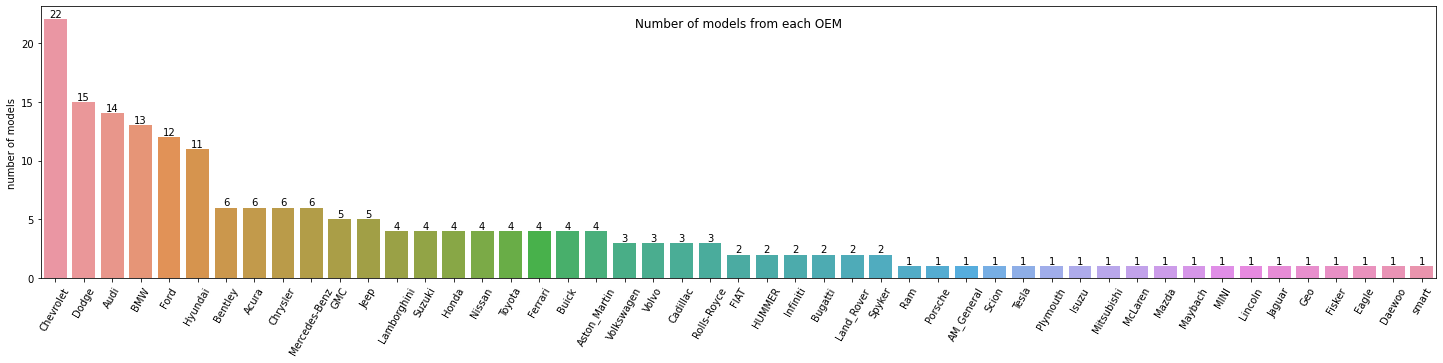

In [25]:
# Number of models from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["OEM"].value_counts().index,y=carsMaster["OEM"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each OEM",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

**Distribution** : Total number of OEMs - 49

The Chevrolet is having 11% of contribution for the various models

The Ram, Porsche, AM General, Jaguar, smart are few models that are contributing only 0.05% of the models

This help to understand about the imbalance of data for OEM and Models in the dataset

**Number of Types available under each Model value**

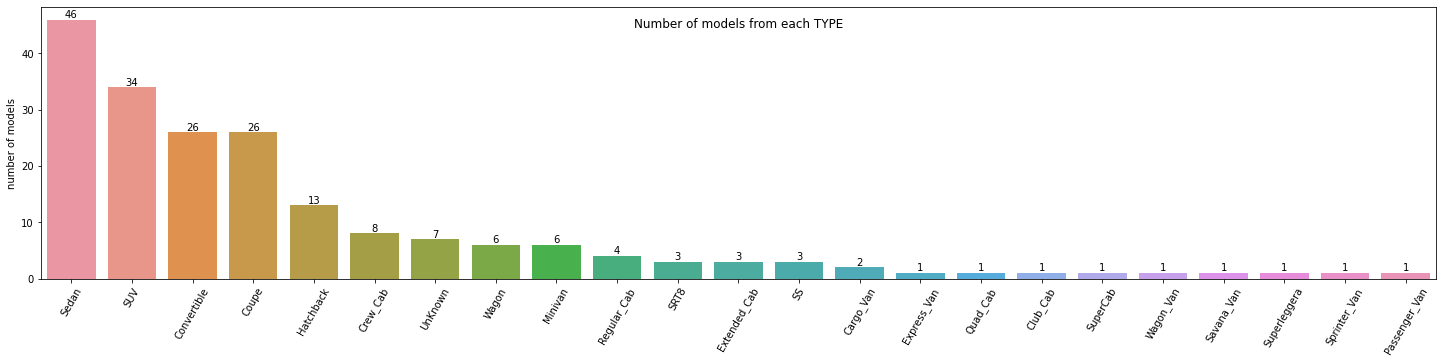

In [26]:
# Number of models from each TYPE of coach
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["TYPE"].value_counts().index,y=carsMaster["TYPE"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

**Distribution** : Total number of Sedan - 46

The Mitsubishi-Sedan is having 23% of contribution for the various models-types

The Club Cab, Wagon Van, Passenger Van are few models types that are contributing only 0.05% of the model-types

This help to understand about the imbalance of data for Model and Types in the dataset

**Number of Models available under each Year**

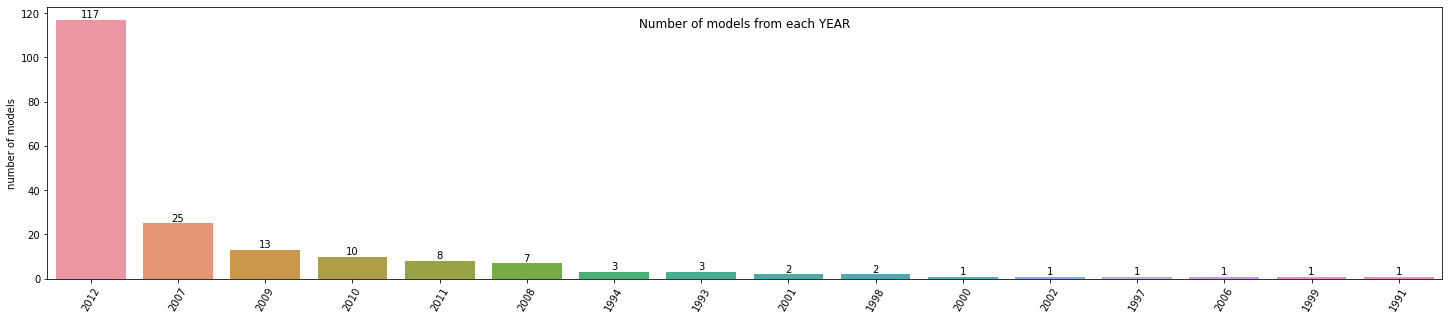

In [27]:
# Number of models from each YEAR
plt.figure(figsize = (25,5))
ax = sns.barplot(x=carsMaster["YEAR"].value_counts().index,y=carsMaster["YEAR"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of models from each YEAR",x=0.5,y=0.9)
plt.ylabel("number of models")
plt.xticks(rotation=60);

**Distribution** : Total number of Models in the year 2012 - 117

The 2012 is having 60% of contribution for the various models for the years

The models from 1991-2000 is having the least contribution of models counting to 0.05%

This help to understand about the imbalance of data for Models and Year in the dataset

**Observations from the Visualization - Bias**

There are imbalances in the dataset might create bias in the model's capabilities

**Bias Type** : Data Collection Bias

**Description** : Bias introduced by the selection of individuals, groups (eg; OEM, Model, Type, Year) in such a way that proper randomization is not achieved. This will fail to ensure that the sample obtained is representative of the population intended to be analyzed.

We could clearly understand that the contribution by few OEM , few Models and selected years are more than others. This will lead to the model being biased towards some OEM-Model-Year cars.

Eg; the model learns more of "Chevrolet" OEM than others. will learn "Sedan" Model than others and 2012 Year Model than others



To reconfirm the findings, let us also read the image data files in to our notebook, and review the distribution once again

**Step 2:** Map training and testing images to its classes.

Read Images for test and train

In [28]:
# reference paths
BASEfldr = 'Car Images/'
TRAINfldr = 'Train Images/'
TESTfldr = 'Test Images/'

**Train Images**

In [29]:
# lets take a record of data about the training imagess
import os
path = os.path.join(BASEfldr,TRAINfldr)
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTrain = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTrain"):
    # we can also do this with if os.isdir() check
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",path+cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (w,h) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTrain["Image"] = imageName
imageMasterTrain["ImagePath"] = imPath
imageMasterTrain["folderName"] = fldrName
imageMasterTrain["height"] = imH
imageMasterTrain["width"] = imW

imScanTrain: 100%|████████████████████████████| 196/196 [00:05<00:00, 36.78it/s]


**Test Images**

In [30]:
# lets take a record of data about the testing imagess
import os
path= os.path.join(BASEfldr,TESTfldr)
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTest = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTest"):
    # we can also do this with if os.isdir() check
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (w,h) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTest["Image"] = imageName
imageMasterTest["ImagePath"] = imPath
imageMasterTest["folderName"] = fldrName
imageMasterTest["height"] = imH
imageMasterTest["width"] = imW

imScanTest: 100%|█████████████████████████████| 196/196 [00:05<00:00, 36.37it/s]


**Compute image size**

Store the image size of height and width in new column called "pixels" 

In [31]:
# compute image sizes
imageMasterTrain["pixels"] = imageMasterTrain.height * imageMasterTrain.width
imageMasterTest["pixels"] = imageMasterTest.height * imageMasterTest.width

**Print Image dimensions**

This will help to visualize the dimensions of the images in range

In [32]:
print("largest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmax()].to_frame().T)
print("tallest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmax()].to_frame().T)
print("widest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmax()].to_frame().T)
print("\n")
print("smallest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmin()].to_frame().T)
print("shortest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmin()].to_frame().T)
print("leanest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmin()].to_frame().T);

largest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  3744.0  5616.0  21026304.0

tallest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  3744.0  5616.0  21026304.0

widest image:


Image                                          ImagePath  \
2573  05945.jpg  Car Images/Train Images/Chevrolet Sonic Sedan ...   

                      folderName  height   width      pixels  
2573  Chevrolet Sonic Sedan 2012  3744.0  5616.0  21026304.0



smallest image:


Image                                          ImagePath  \
2294  00097.jpg  Car Images/Train Images/Chevrolet Corvette Ron...   

                                           folderName height width  pixels  
2294  Chevrolet Corvette Ron Fellows Edition Z06 2007   58.0  78.0  4524.0

shortest image:


Image                                          ImagePath  \
5107  04047.jpg  Car Images/Train Images/Geo Metro Convertible ...   

                      folderName height  width  pixels  
5107  Geo Metro Convertible 1993   57.0  101.0  5757.0

leanest image:


Image                                          ImagePath  \
2294  00097.jpg  Car Images/Train Images/Chevrolet Corvette Ron...   

                                           folderName height width  pixels  
2294  Chevrolet Corvette Ron Fellows Edition Z06 2007   58.0  78.0  4524.0

**Resizing Images**

    Resizing images is a critical preprocessing step in computer vision. Machine Learning models  train faster on smaller images and they need images of same size as input.

**Some of the Best Practices**

    1. To decide on what should be the size of the images, a good strategy is to employ 
    progressive  resizing. eg; we can start with all images resized to the smallest one.

    2. Progressive resizing will train an initial model with very small input images and gauge 
    performance. We can use those weights as the starting point for the next model with larger 
    input images.

    3. Downsizing larger images to match the size of smaller images is often a better bet 
    than increasing the size of small images to be larger.

    4. In general, it is safer to maintain the raw image aspect ratio and resize 
    proportionally.

    5. Make use of image resizing methods like interpolation so that the resized images 
    do not lose much of their perceptual character.

**Image Interpolation**

    Image interpolation occurs when you resize or distort your image from one pixel grid to 
    another. There are two types of interpolation. 
    
    1. Adaptive : Adaptive methods change depending on what they are interpolating
    2. Non-adaptive : Non-adaptive methods treat all pixels equally.

    Higher-Order Interpolation techniques like Spline and Sinc are computationally costly, 
    where as Nearest Neighbor, bilinear are computationally less expensive.

**How to best resize the given images?**

    We can optimally learn representations of images for a given resolution by consistently 
    improving the performance of the common vision models. We can use bilinear interpolation with learnable image resizing module using keras will help to acheive this

    Ref: https://keras.io/examples/vision/learnable_resizer/


**Initial Image Size**

Based on above review, we shall restrict the image size fed to the network at 50x50 pixels, so as not to detoriate lower resolution images and thus affect model capabilities

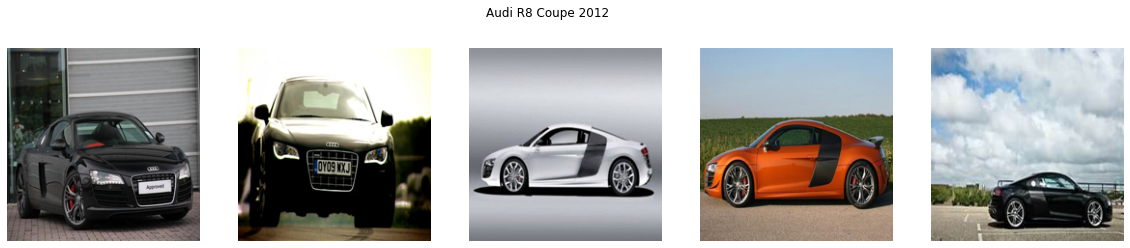

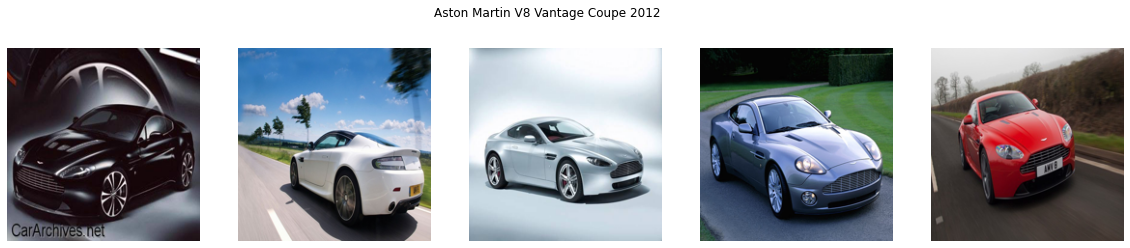

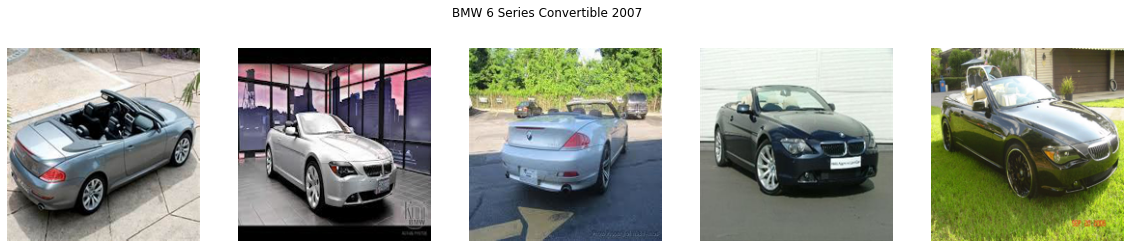

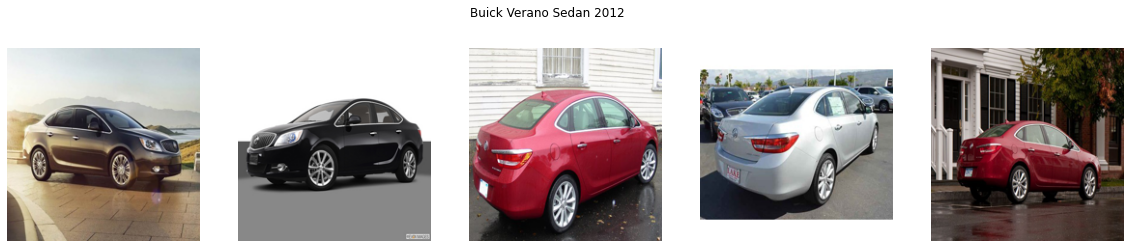

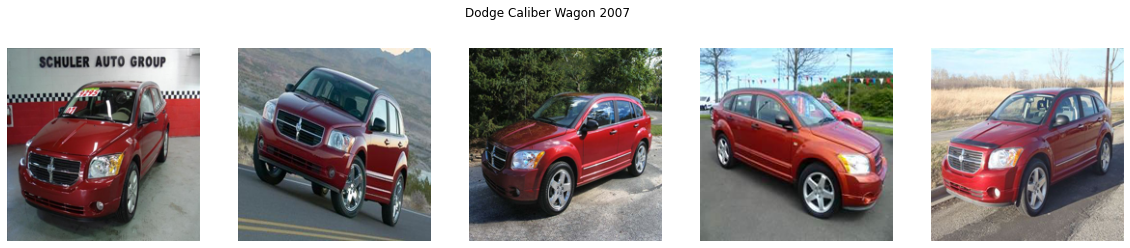

In [33]:
# display 5 random images of 5 random classes
classes = np.random.choice(imageMasterTrain.folderName.unique(),5,replace=False)
for cls in classes:
    dtmp = imageMasterTrain.loc[imageMasterTrain.folderName == cls]
    images = np.random.choice(dtmp.ImagePath.values,5,replace=False)
    plt.figure(figsize=(20,4))
    plt.suptitle(cls)
    for i,img in enumerate(images):
        img = Image.open(img).resize((200,200))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

**Step 3:** Map training and testing images to its annotations

Read Bounding box and annotations

Having connected to the images directories, lets also add the annotations, and add the bounding boxes to the images

In [34]:
# let us read the annotations datafile to pandas dataframe
trainAnnot = pd.read_csv('./Annotations/Train Annotations.csv')
testAnnot = pd.read_csv('./Annotations/Test Annotation.csv')
Acols = ['Image Name', 'x1', 'y1', 'x2','y2', 'Image class']
trainAnnot.columns = Acols
testAnnot.columns = Acols

In [35]:
#review the content
trainAnnot.head()

Image Name   x1   y1    x2    y2  Image class
0  00001.jpg   39  116   569   375           14
1  00002.jpg   36  116   868   587            3
2  00003.jpg   85  109   601   381           91
3  00004.jpg  621  393  1484  1096          134
4  00005.jpg   14   36   133    99          106

**Merge all information of images, annotations, bounding box to single DataFrame**

In [36]:
# create all-consolidated dataframes
trainDF = pd.merge(imageMasterTrain,trainAnnot,how='outer',left_on='Image',right_on='Image Name')
testDF = pd.merge(imageMasterTest,testAnnot,how='outer',left_on='Image',right_on='Image Name')

display(trainDF.head(),testDF.head())

Image                                          ImagePath  \
0  04544.jpg  Car Images/Train Images/AM General Hummer SUV ...   
1  00163.jpg  Car Images/Train Images/AM General Hummer SUV ...   
2  00462.jpg  Car Images/Train Images/AM General Hummer SUV ...   
3  00522.jpg  Car Images/Train Images/AM General Hummer SUV ...   
4  00707.jpg  Car Images/Train Images/AM General Hummer SUV ...   

                   folderName  height  width    pixels Image Name  x1  y1  \
0  AM General Hummer SUV 2000   200.0  339.0   67800.0  04544.jpg  18  18   
1  AM General Hummer SUV 2000   525.0  700.0  367500.0  00163.jpg  46  84   
2  AM General Hummer SUV 2000    64.0   85.0    5440.0  00462.jpg   5   8   
3  AM General Hummer SUV 2000    71.0   94.0    6674.0  00522.jpg   6   7   
4  AM General Hummer SUV 2000   439.0  700.0  307300.0  00707.jpg  26  32   

    x2   y2  Image class  
0  328  190            1  
1  661  428            1  
2   83   58            1  
3   94   68            1  
4  677  418            1

Image                                          ImagePath  \
0  03246.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
1  00076.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
2  00457.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
3  00684.jpg  Car Images/Test Images/AM General Hummer SUV 2...   
4  01117.jpg  Car Images/Test Images/AM General Hummer SUV 2...   

                   folderName  height  width    pixels Image Name   x1  y1  \
0  AM General Hummer SUV 2000    41.0  101.0    4141.0  03246.jpg    9   3   
1  AM General Hummer SUV 2000    64.0   96.0    6144.0  00076.jpg   11  13   
2  AM General Hummer SUV 2000   144.0  250.0   36000.0  00457.jpg   31  20   
3  AM General Hummer SUV 2000   216.0  373.0   80568.0  00684.jpg  111  54   
4  AM General Hummer SUV 2000   600.0  800.0  480000.0  01117.jpg   45  39   

    x2   y2  Image class  
0   93   41            1  
1   84   60            1  
2  226  119            1  
3  365  190            1  
4  729  414            1

**Merge OEM,MODEL,Type,Year with the above dataframe**

In [37]:
# lets merge the OEM, MODEL, TYPE & YEAR data
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')

In [38]:
# update class index to start from ZERO
trainDF["Image class"] = trainDF["Image class"]-1
testDF["Image class"] = testDF["Image class"]-1

In [39]:
# merge cars_names_and_make csv data with the annotation class name field
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='Image class',right_index=True)
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='Image class',right_index=True)
# though this will duplicate the already exisiting folderName, fullNames columns, this adds a cross check for data correctness

**Validate data for any mismatch during merging**

After doing the cross merged and synced with "Train/Test Annotations.csv", "Car names and make.csv" and the images in the "Train/Test images folders", it is found to have no mismatch of information

In [40]:
# review if any mismatches available
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_x])
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_y])
display(trainDF.loc[trainDF.fullNames_x!=trainDF.fullNames_y])
display(testDF.loc[testDF.folderName!=testDF.fullNames_x])
display(testDF.loc[testDF.folderName!=testDF.fullNames_y])
display(testDF.loc[testDF.fullNames_x!=testDF.fullNames_y])

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

Empty DataFrame
Columns: [Image, ImagePath, folderName, height, width, pixels, Image Name, x1, y1, x2, y2, Image class, fullNames_x, OEM_x, MODEL_x, TYPE_x, YEAR_x, fullNames_y, OEM_y, MODEL_y, TYPE_y, YEAR_y]
Index: []

[0 rows x 22 columns]

**Cleanup - Unwanted columns**

Remove unwanted columns and make the dataframe more readable

In [41]:
# finalize the images dataframe
trainDF = trainDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image class","OEM_x","MODEL_x","TYPE_x","YEAR_x",]]
testDF = testDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image class","OEM_x","MODEL_x","TYPE_x","YEAR_x",]]

trainDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image_class","OEM","MODEL","TYPE","YEAR"]
testDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","Image_class","OEM","MODEL","TYPE","YEAR"]


In [42]:
trainDF.sample(2)

Image                                          ImagePath   x1   y1  \
7534  05282.jpg  Car Images/Train Images/Suzuki Kizashi Sedan 2...  256  310   
978   05688.jpg  Car Images/Train Images/Audi S4 Sedan 2007/056...   21  190   

        x2   y2  height   width                 folderName  Image_class  \
7534  1504  727  1200.0  1920.0  Suzuki Kizashi Sedan 2012          181   
978    750  555   600.0   800.0         Audi S4 Sedan 2007           23   

         OEM    MODEL   TYPE  YEAR  
7534  Suzuki  Kizashi  Sedan  2012  
978     Audi       S4  Sedan  2007

In [43]:
testDF.sample(2)

Image                                          ImagePath  x1   y1  \
3297  02171.jpg  Car Images/Test Images/Daewoo Nubira Wagon 200...  34   60   
3956  03960.jpg  Car Images/Test Images/Eagle Talon Hatchback 1...  54  134   

       x2   y2  height  width                  folderName  Image_class  \
3297  217  158   188.0  250.0    Daewoo Nubira Wagon 2002           81   
3956  566  411   480.0  640.0  Eagle Talon Hatchback 1998           97   

         OEM   MODEL       TYPE  YEAR  
3297  Daewoo  Nubira      Wagon  2002  
3956   Eagle   Talon  Hatchback  1998

**Check for null values**

In [44]:
# review for any missing values
trainDF.isna().sum()

Image          0
ImagePath      0
x1             0
y1             0
x2             0
y2             0
height         0
width          0
folderName     0
Image_class    0
OEM            0
MODEL          0
TYPE           0
YEAR           0
dtype: int64

In [45]:
testDF.isna().sum()

Image          0
ImagePath      0
x1             0
y1             0
x2             0
y2             0
height         0
width          0
folderName     0
Image_class    0
OEM            0
MODEL          0
TYPE           0
YEAR           0
dtype: int64

**Step 4:** Display images with bounding box

Visualization - Images with bounding box and annotations - 5 Nos

2022-07-10 15:59:32.733384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 15:59:32.763375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 15:59:32.763538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 15:59:32.764180: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

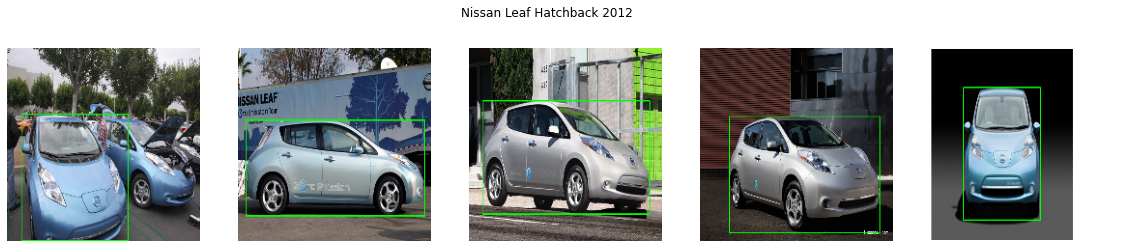

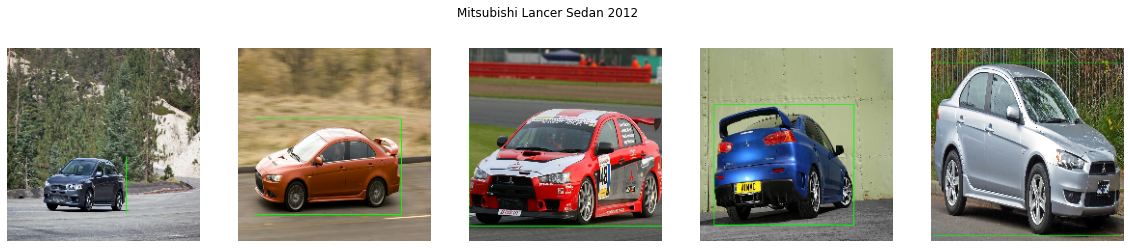

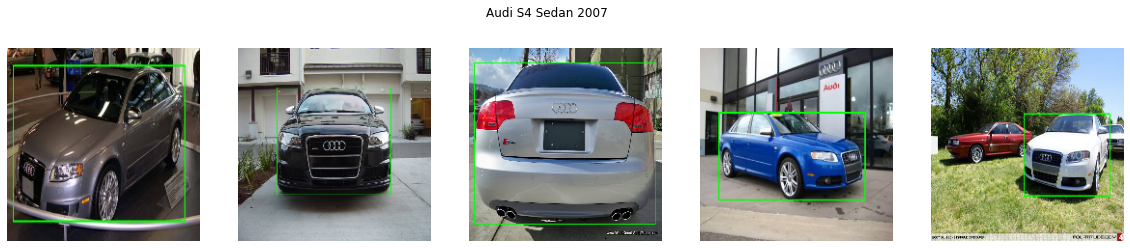

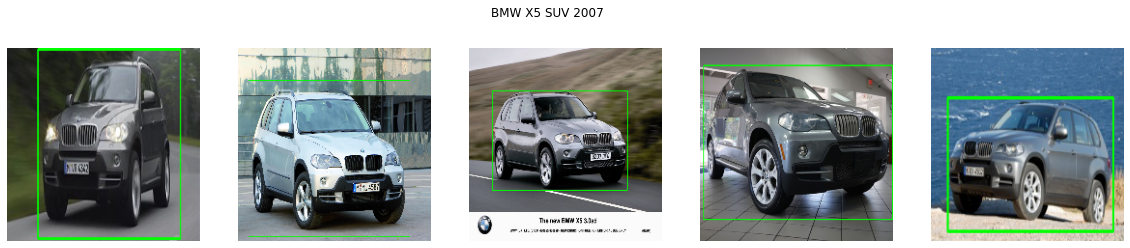

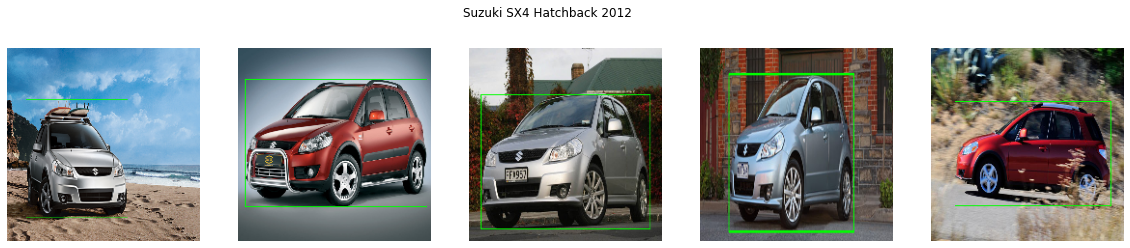

In [46]:
# display 5 random images of 5 random classes with respective bounding boxes from the annotations csv
classes = np.random.choice(trainDF.folderName.unique(),5,replace=False)
tfi = tf.keras.preprocessing.image
for cls in classes:
    dtmp = trainDF.loc[trainDF.folderName == cls]
    ind = np.random.choice(dtmp.index,5,replace=False)
    images = dtmp.loc[ind]["ImagePath"]
    x1 = dtmp.loc[ind]["x1"].values
    y1 = dtmp.loc[ind]["y1"].values
    x2 = dtmp.loc[ind]["x2"].values
    y2 = dtmp.loc[ind]["y2"].values

    plt.figure(figsize=(20,4))
    plt.suptitle(cls)
    for i,img in enumerate(images):
        img = tfi.img_to_array(tfi.load_img(img))
        cv2.rectangle(img,(x1[i],y1[i]),(x2[i],y2[i]),(0,255,0),2)
        img = tfi.array_to_img(tf.image.resize(img,(200,200)))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

**Visualize**

**Number of Images per OEM**

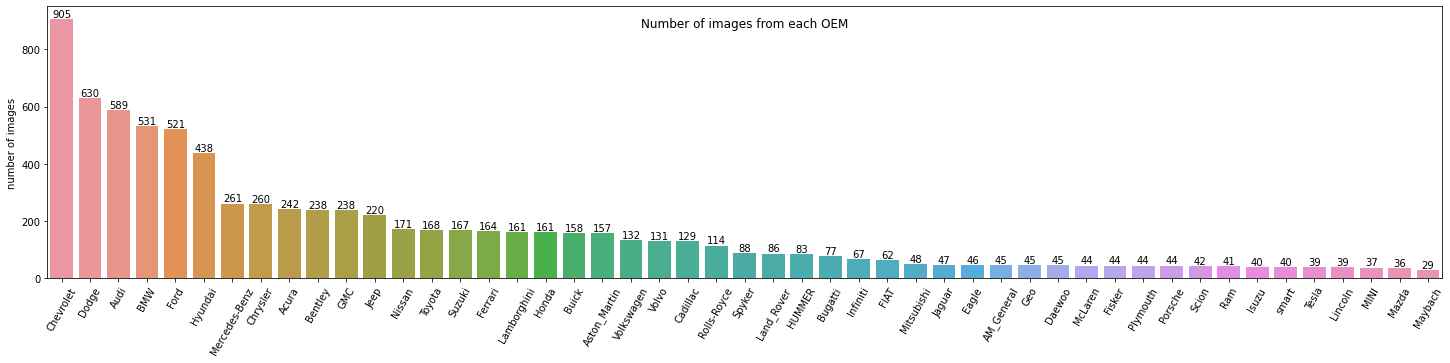

In [47]:
# Number of images from each OEM
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["OEM"].value_counts().index,y=trainDF["OEM"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each OEM",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

**Distribution** : Total number of OEM - Chevrolet - 905

The Chevrolet is having 60% of contribution for the images in train dataset

The Maybach is having the least contribution of images in train dataset, as 0.03%

This help to understand about the imbalance of data for OEM-images dataset

**Visualize**

**Number of Images per OEM-Type**

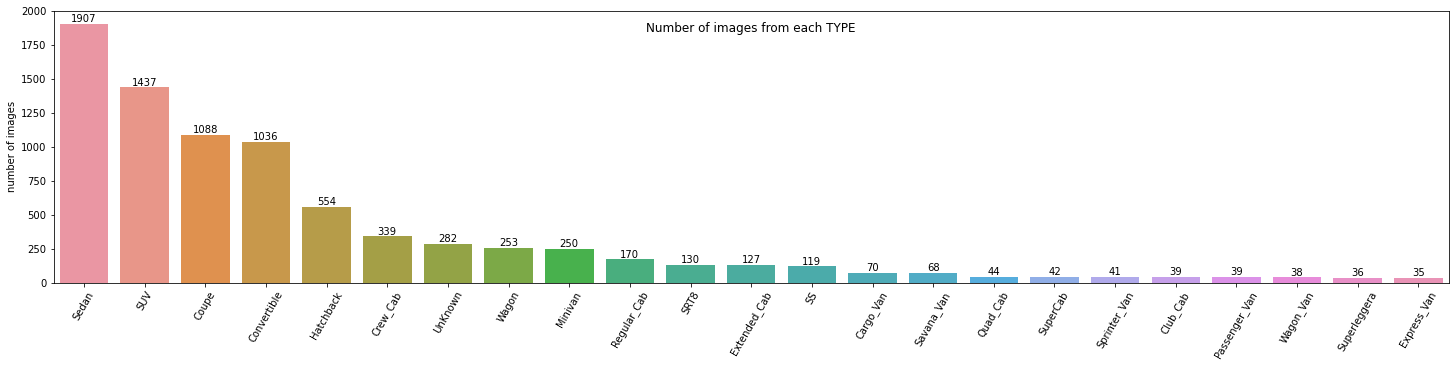

In [48]:
# Number of images from each TYPE
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["TYPE"].value_counts().index,y=trainDF["TYPE"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

**Distribution** : Total number of Mitsubishi-Sedan - 1907

The Mitsubishi-Sedan is having 26% of contribution for the images in train dataset

The Express Van is having the least contribution of images in train dataset, as 0.04%

This help to understand about the imbalance of data for Model-images dataset

**Visualize**

**Number of Images per Year**

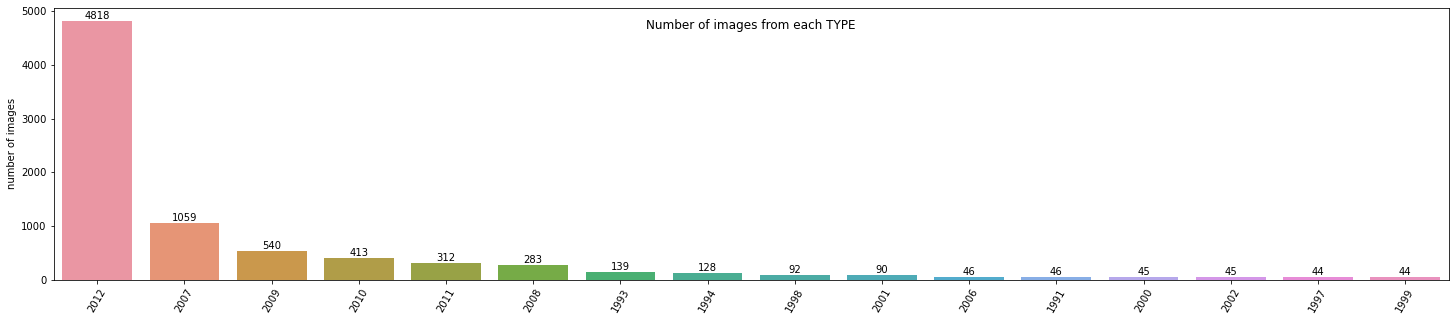

In [49]:
# Number of images from each YEAR
plt.figure(figsize = (25,5))
ax = sns.barplot(x=trainDF["YEAR"].value_counts().index,y=trainDF["YEAR"].value_counts().values) # display bars
ax.bar_label(ax.containers[0]) # display counts
plt.title("Number of images from each TYPE",x=0.5,y=0.9)
plt.ylabel("number of images")
plt.xticks(rotation=60);

**Distribution** : Total number of images for year 2012 - 4818

The 2012 is having 60% of contribution for the images in train dataset

The 1997-1999 is having the least contribution of images in train dataset, as 0.05%

This help to understand about the imbalance of data for Year-images dataset

**Distribution of Support**

The box plot shows how the distribution of images are there for each class / category

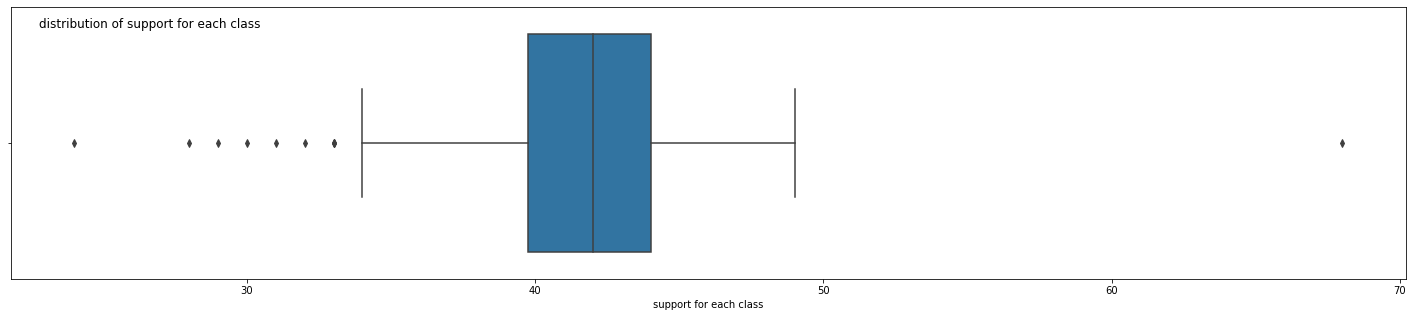

In [50]:
# distribution of support for each class
plt.figure(figsize = (25,5))
sns.boxplot(x=trainDF["folderName"].value_counts())
plt.xlabel("support for each class")
plt.title("distribution of support for each class",x=0.1,y=0.9);

**Print Cross distribution of the Type from each OEM**

In [51]:
# let us study the cross distribution of the TYPE of car from each OEM
pivot = trainDF.groupby(by=["OEM","TYPE","YEAR"])["Image"].count().to_frame()
pivot.reset_index(inplace=True)
pivot.columns=["OEM","TYPE","YEAR","COUNTS"]
pivot

OEM         TYPE  YEAR  COUNTS
0    AM_General          SUV  2000      45
1         Acura    Hatchback  2012      39
2         Acura        Sedan  2012     116
3         Acura      UnKnown  2001      45
4         Acura      UnKnown  2008      42
..          ...          ...   ...     ...
145  Volkswagen    Hatchback  2012      86
146       Volvo    Hatchback  2012      42
147       Volvo          SUV  2007      43
148       Volvo        Sedan  1993      46
149       smart  Convertible  2012      40

[150 rows x 4 columns]

**Print distribution of support images**

The combinations are only within 40~50 images each, whith few extreme counts

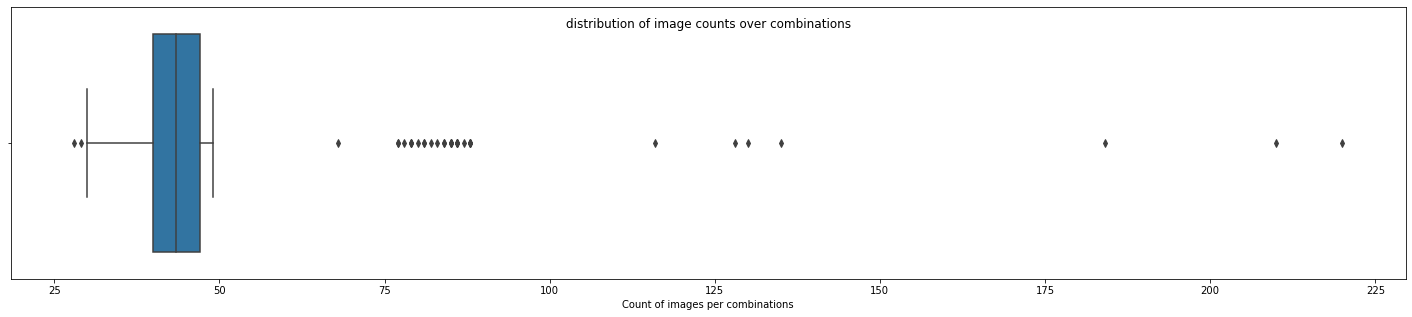

In [52]:
# distribution of support for each class
plt.figure(figsize = (25,5))
sns.boxplot(x=pivot.COUNTS)
plt.xlabel("Count of images per combinations")
plt.title("distribution of image counts over combinations",x=0.5,y=0.9);

**Print Combination with more than 50 image (Average)**

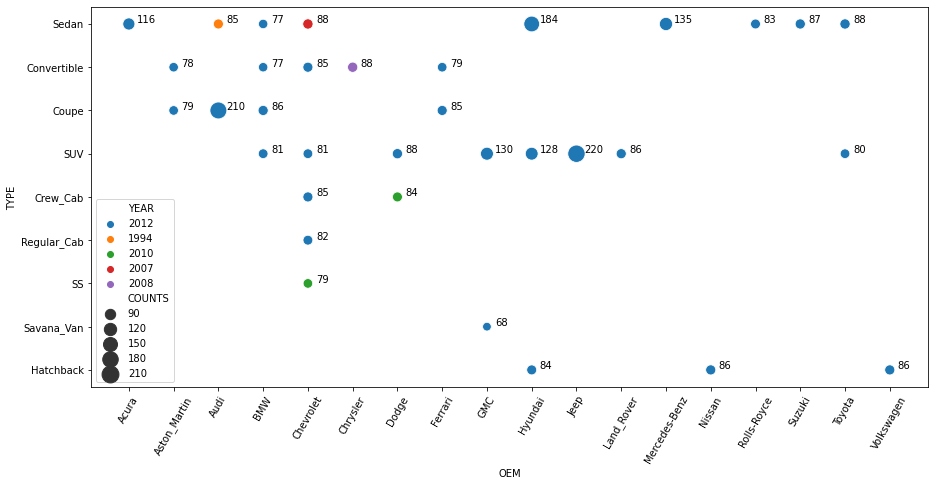

In [53]:
# combinations with more than 50 images each
graphDF = pivot.loc[pivot.COUNTS>50]
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x=graphDF.OEM,y=graphDF.TYPE,hue=graphDF.YEAR,size=graphDF.COUNTS,sizes=(75,300))
plt.xticks(rotation=60)
plt.legend(loc='lower left')

for i in range(len(graphDF)):
    xpos = (np.argwhere(graphDF.OEM.unique()==graphDF.OEM.values[i])[0][0])# / graphDF.OEM.nunique()
    ypos = (np.argwhere(graphDF.TYPE.unique()==graphDF.TYPE.values[i])[0][0])# / graphDF.TYPE.nunique()
    ax.annotate(text=str(graphDF.COUNTS.values[i]), xy=(xpos,ypos), xycoords='data', 
                xytext=(8,1), textcoords='offset points')

**Print Combination with less than 35 image**

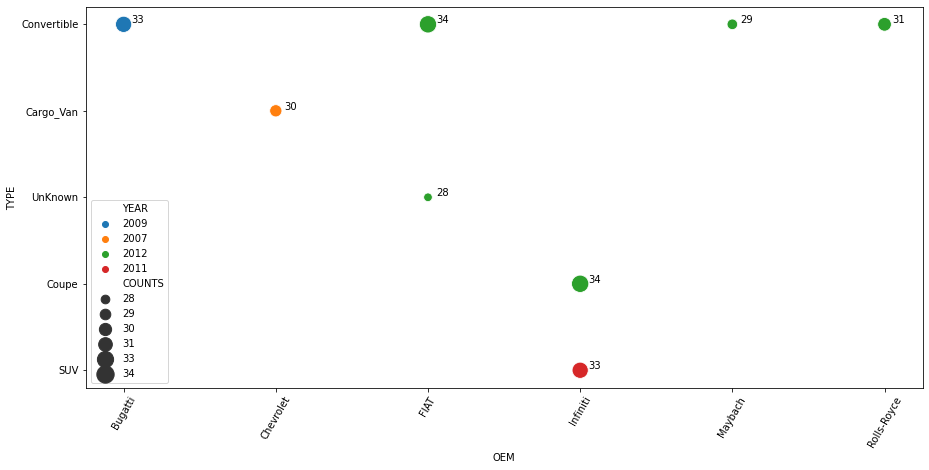

In [54]:
# combinations with less than 35 images each
graphDF = pivot.loc[pivot.COUNTS<35]
plt.figure(figsize=(15,7))
ax = sns.scatterplot(x=graphDF.OEM,y=graphDF.TYPE,hue=graphDF.YEAR,size=graphDF.COUNTS,sizes=(75,300))
plt.xticks(rotation=60)
plt.legend(loc='lower left')

for i in range(len(graphDF)):
    xpos = (np.argwhere(graphDF.OEM.unique()==graphDF.OEM.values[i])[0][0])# / graphDF.OEM.nunique()
    ypos = (np.argwhere(graphDF.TYPE.unique()==graphDF.TYPE.values[i])[0][0])# / graphDF.TYPE.nunique()
    ax.annotate(text=str(graphDF.COUNTS.values[i]), xy=(xpos,ypos), xycoords='data', 
                xytext=(8,1), textcoords='offset points')

**Conclusion**

    1. All the data preprocessing & compilation have been completed so far
    2. The data were imported and mapped against their respective classses & annotations
    3. Comprehensive dataframes for training & testing datasets were created and could be used 
    with generators for Deep Learning Networks
    
### **MILESTONE 1 COMPLETE**

for future codes, import the following dataframes as final output from this Milestone1<br>
* trainDF
* testDF

use following code to invoke & import data<br>
***from*** Milestone1 ***import*** trainDF, testDF;